In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils

import numpy as np
from matplotlib import pyplot as plt

from models import CNN1D_1l_RNN
from train import train_lambda, eval_lambda

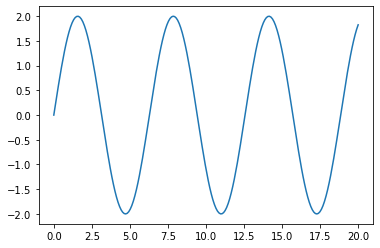

In [2]:
signal = lambda t: 2*np.sin(t)# + t# + np.random.normal(loc=0.0, scale=0.3, size=t.shape)
ticks = np.linspace(0, 20, 200)
plt.plot(ticks, signal(ticks))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
torch.manual_seed(1)
f = 128
tr = 48

In [5]:
lstm = CNN1D_1l_RNN(32, int(tr/0.1), stacked=3, future = f, cell_type="LSTM")
train_lambda(lstm, signal, future = f, time_range=tr, epochs = 1000, dev = device)

  0%|          | 0/1000 [00:00<?, ?it/s]

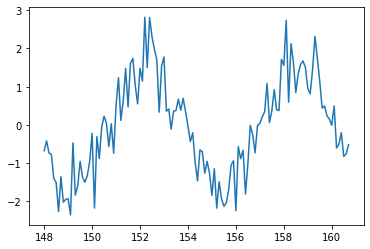

In [7]:
gru = CNN1D_1l_RNN(32, int(tr/0.1), stacked=6, future = f, cell_type="GRU")
train_lambda(gru, signal, future = f, time_range=tr, epochs = 1000, dev = device, lr=0.0003)